In [26]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [27]:
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

In [28]:
from plotting import format_plot, save_plot
from constants import JULIAN_DAY
from spice_tools import as_et, as_utc
from simulation_tools import load_simulation_results

In [29]:
ref_epoch = as_et("1981 DEC 22")

# Knocke albedo/emissivity model

In [30]:
def calculate_albedo(t, latitude):
    a0 = 0.34
    c0 = 0
    c1 = 0.1
    c2 = 0
    a2 = 0.29
    omega = 2 * np.pi / 365.25

    days_since_reference_epoch = (t - ref_epoch) / JULIAN_DAY

    a1 = c0 + c1 * np.cos(omega * days_since_reference_epoch) + c2 * np.sin(omega * days_since_reference_epoch)

    P1 = np.sin(latitude)
    P2 = (3 * np.sin(latitude)**2 - 1) / 2

    a = a0 + a1 * P1 + a2 * P2

    return a

calculate_albedo(as_et("1977 JAN 08 01:46:13"), np.radians(90))


0.725592271381903

In [31]:
def calculate_emissivity(t, latitude):
    e0 = 0.68
    k0 = 0
    k1 = -0.07
    k2 = 0
    e2 = -0.18
    omega = 2 * np.pi / 365.25

    days_since_reference_epoch = (t - ref_epoch) / JULIAN_DAY

    e1 = k0 + k1 * np.cos(omega * days_since_reference_epoch) + k2 * np.sin(omega * days_since_reference_epoch)

    P1 = np.sin(latitude)
    P2 = (3 * np.sin(latitude)**2 - 1) / 2

    e = e0 + e1 * P1 + e2 * P2

    return e

calculate_emissivity(as_et("2010 DEC 22"), np.radians(45))


0.5855029824562078

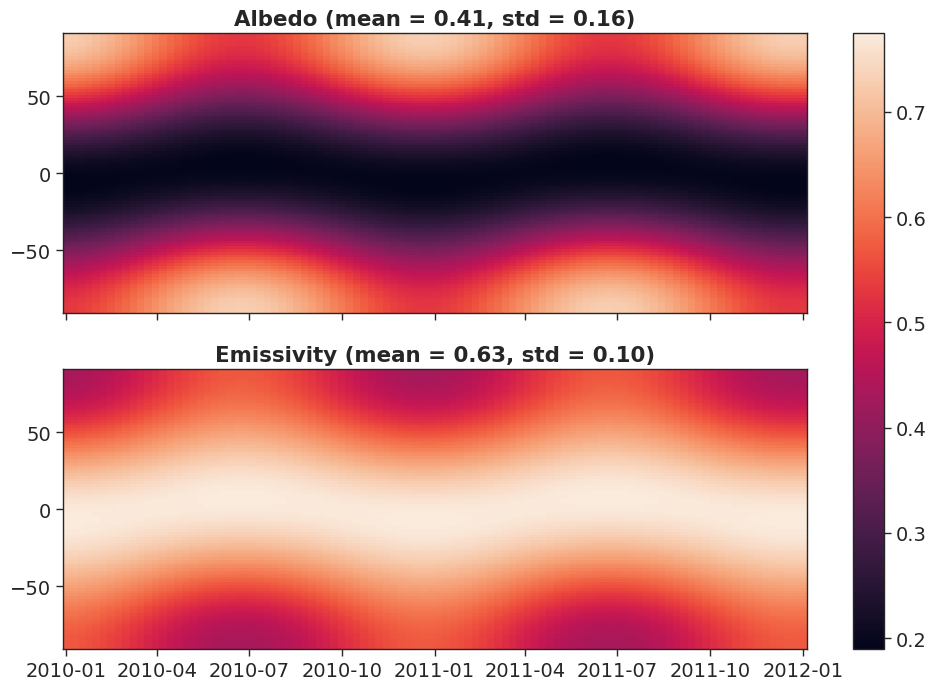

In [32]:
def plot_albedo_emissivity():
    fig, (ax_a, ax_e) = plt.subplots(2, 1, sharex="all", sharey="all", figsize=(12, 8))

    t_start = as_et("2010 JAN 1")
    t_end = as_et("2012 JAN 1")

    t, lat = np.meshgrid(
        np.linspace(t_start, t_end, 100),
        np.linspace(np.radians(-90), np.radians(90), 100))
    
    t_dt = pd.to_datetime([as_utc(t, sec_prec=10) for t in np.linspace(t_start, t_end, 100)])
    lat_deg = np.linspace(-90, 90, 100)
    
    a = np.vectorize(calculate_albedo)(t, lat)
    e = np.vectorize(calculate_emissivity)(t, lat)

    vmin = min(a.min(), e.min())
    vmax = max(a.max(), e.max())
    
    ax_a.pcolormesh(t_dt, lat_deg, a, vmin=vmin, vmax=vmax)
    cbar = ax_e.pcolormesh(t_dt, lat_deg, e, vmin=vmin, vmax=vmax)

    ax_a.set_title(f"Albedo (mean = {a.mean():.2f}, std = {a.std():.2f})")
    ax_e.set_title(f"Emissivity (mean = {e.mean():.2f}, std = {e.std():.2f})")

    plt.colorbar(cbar, ax=[ax_a, ax_e])

plot_albedo_emissivity()

As expected, poles have higher albedo and are less emissive. The Northern Hemisphere is brighter and less emissive in Northern winter.

### Unit test data

In [33]:
(
    calculate_albedo(as_et("2005 AUG 19 13:46:17"), np.radians(29.73)),
    calculate_albedo(as_et("2012 DEC 21 17:26:17"), np.radians(81.43)),
    calculate_albedo(as_et("2022 APR 28 22:49:57"), np.radians(0)),
    calculate_albedo(as_et("1977 JAN 08 01:46:13"), np.radians(90)),
)

(0.2752338314886392,
 0.7192237282075249,
 0.19500000000000003,
 0.725592271381903)

In [34]:
(
    calculate_emissivity(as_et("2005 AUG 19 13:46:17"), np.radians(29.73)),
    calculate_emissivity(as_et("2012 DEC 21 17:26:17"), np.radians(81.43)),
    calculate_emissivity(as_et("2022 APR 28 22:49:57"), np.radians(0)),
    calculate_emissivity(as_et("1977 JAN 08 01:46:13"), np.radians(90)),
)

(0.7223209069278839, 0.4367772746818569, 0.77, 0.43308541003266804)